# Identifying Master Regulator Dependencies in Pediatric Osteosarcoma Using VIPER

### CBMF4761 Computational Genomics Spring 2019 Final Project
### Jovana Pavisic (jp3679)

In [2]:
# Installing Required Packages and Libraries
suppressPackageStartupMessages(library(viper))       # Bioconductor: Viper MR analysis pipeline
suppressPackageStartupMessages(library(n1platform))  # install from github (not sure if publicly available yet, minimally used in this code)
suppressPackageStartupMessages(library(factoextra))  # install_github("kassambara/factoextra"), another clustering and visualization tool
suppressPackageStartupMessages(library(matrixStats)) # CRAN, basic statistics
suppressPackageStartupMessages(library(rcompanion))  # CRAN, additional statistical analyses
suppressPackageStartupMessages(library(NbClust))     # CRAN, Determining the best number of clusters
suppressPackageStartupMessages(library(cluster))     # CRAN, Perform clustering analysis
suppressPackageStartupMessages(library(RColorBrewer))# CRAN, for making pretty plots
suppressPackageStartupMessages(library(gplots))      # CRAN, for making heatmaps
suppressPackageStartupMessages(library(magrittr))    # CRAN
suppressPackageStartupMessages(library(survival))    # CRAN, Perform survival Analysis
suppressPackageStartupMessages(library(survminer))   # CRAN, Gets information out of survival objects
suppressPackageStartupMessages(library(tidyverse))   # Other tidy tools
suppressPackageStartupMessages(library(readxl))

Warning message:
“package ‘ggplot2’ was built under R version 3.5.2”Warning message:
“package ‘rcompanion’ was built under R version 3.5.2”Warning message:
“package ‘cluster’ was built under R version 3.5.2”Warning message:
“package ‘gplots’ was built under R version 3.5.2”Warning message:
“package ‘survival’ was built under R version 3.5.2”Warning message:
“package ‘tibble’ was built under R version 3.5.2”Warning message:
“package ‘tidyr’ was built under R version 3.5.2”Warning message:
“package ‘purrr’ was built under R version 3.5.2”Warning message:
“package ‘dplyr’ was built under R version 3.5.2”Warning message:
“package ‘stringr’ was built under R version 3.5.2”Warning message:
“package ‘forcats’ was built under R version 3.5.2”Warning message:
“package ‘readxl’ was built under R version 3.5.2”

## ARACNe to generate tumor gene regulatory network (interactome)
In this project, I used a wrapper available in the Califano Lab directory of the C2B2 cluster to run ARACNe-AP (Algorithm for the Reconstruction of Accurate Cellular Networks with Adaptive Partitioning) whose details are published in:

Lachmann A, Giorgi FM, Lopez G, Califano A. ARACNe-AP: gene network reverse engineering through adaptive partitioning inference of mutual information. Bioinformatics. 2016 Jul 15;32(14):2233-5. doi: 10.1093/bioinformatics/btw216. Epub 2016 Apr 23.

ARACNe-AP can be obtained from GitHub at https://github.com/califano-lab/ARACNe-AP which also provides detailed instructions for building and running the software.

The algorithm requires a gene expression matrix (I used the logTPM counts for the 160 samples from TARGET, DFCI and UCSF) and list of potential regulators (transcription factors, co-transcription factors, and signaling proteins) which I had available from other members of the Califano lab. The list of regulators is included in the 'regulators.csv' file, however the original gene expression matrix used could not be due to data sharing issues. However, one can run ARACNe-AP successfully on the provided TARGET only logTPM counts as an example ('TARGET_tpm.txt'). The wrapper available on the cluster allows for more rapid implementation of ARACNe where each bootstrap can be run on a separate cluster node. It primarily implements the code below which allows one to run ARACNe on their local machine through R, however this will be highly time consuming requiring multiple days to run. Therefore, we have also provided the final interactome generated when running this code using the TARGET only logTPM counts both as a regulon object required by the subsequent VIPER software ('OS_target_interactome.rds') and as a table of regulator, target, their mutual information score and associated p-value for all final interactions included in the network ('final_network.txt').

### Can also skip this step as time consuming and proceed to VIPER analysis of protein activity
The appropriate pediatric OS gene expression matrix and necessary interactomes for running VIPER will be provided in that step without running the code below.

In [48]:
## Generating the appropriate gene expression matrix ##

# Load the gene expression data (rows are genes as Ensemble IDs, columns are 84 TARGET pt samples, and each cell is TPM)
target_dset <- as.matrix(read.delim("TARGET_TPM.txt", header = TRUE, sep = "\t", row.names=1, stringsAsFactors = FALSE))

# Convert Ensemble IDs to Entrez IDs required by ARACNe/VIPER. Use provided ens2entrez.rda. 
# As one Entrez ID maps to multiple Ensemble IDs, must sum these counts.
# The function EnsEntrez both coverts all ensemble IDs to entrez IDs when available (removes genes that don't have entrez ID) 
# and sums the counts of all of the same entrez IDs.
load(file = "ens2entrez.rda")
EnsEntrez <- function(dset){
  rn <- ens2entrez[rownames(dset)]
  pos_rn <- !is.na(rn)
  dset <- dset[pos_rn,]
  rn <- rn[pos_rn]
  dset_Entrez <- matrix(NA,nr=length(unique(rn)),nc=ncol(dset))
  rownames(dset_Entrez) <- as.character(unique(rn)); colnames(dset_Entrez) <- colnames(dset)
  z=0
  for(m in unique(rn)){
    vec <- names(rn)[rn==m]
    if(length(vec) > 1) {output <- rowSums(dset[vec,])}else{
      output <- dset[vec,]
    }
    dset_Entrez[as.character(m),] <- output
    z=z+1; 
  }
  return(dset_Entrez)
}

# Use above function to generate matrix with Entrez IDs and TPMs for each gene across the TARGET samples.
# We have 20,895 rows (genes) and 84 columns (patient samples).
target.tpm.mat <- EnsEntrez(target_dset) 

# Log transform TPM counts in order to make them log normally distributed across genes for further analyses.
target.log2tpm.mat <- apply(target.tpm.mat, 2, function(i){log(i+0.25)})

# Adjust TARGET sample names to match those of clinical files for easier comparison in future.
colnames(target.log2tpm.mat) <- colnames(target.log2tpm.mat) %>% gsub(".01A.01R", "", .) %>% gsub("\\.", "-", .)

ARACNe-AP runs optimally when samples are available across the spectrum of a tumor (all possible tissue sites, metastatic/relapsed samples, etc.) providing the full diversity of regulator-target interactions and when there are minimal batch effects among the samples related to the underlying RNA sequencing which can generate false positive interactions. It also typically requires a minimum of 100 samples. Therefore, originally, I ran ARACNe on 160 samples from TARGET, DFCI and UCSF and used the code below to evaluate the degree of batch effects as noted by the segregation of samples on PCA by source site and the fraction of variance explained by the source site using an available function in the Califano lab. I saw that ~22% of the variance was explained by source site and there was moderate segregation on the PCA plot at least between the TARGET and UCSF/DFCI samples. I additionally saw clear outliers on the PCA plot and removed samples outside of the 95% CI from the ARACNe analysis, thus my final analysis was done on 148 samples. The code below, however is run on only the TARGET samples as an example.

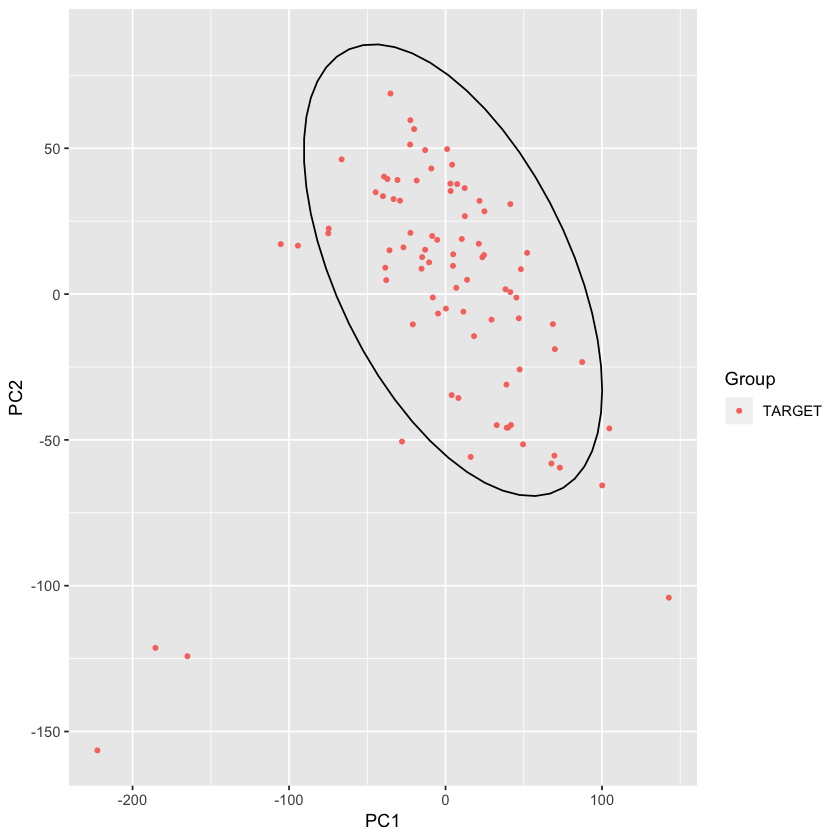

In [3]:
# Scale the data to get a gene expression signature
ges.mat <- t(apply(target.log2tpm.mat,1,function(x){
    y <- (x - mean(x))/sd(x)
    return(y)
}))
ges.mat <- ges.mat[is.finite(rowSums(ges.mat)),]

# PCA of the data
current.pca <- prcomp(x = t(ges.mat))
# Plotting the data by the first two PCA components
plot.data <- as.data.frame(current.pca$x[,1:2])
plot.data$Group <- c(rep("TARGET",times = 84))#,rep("DFCI",times = 35),rep("UCSF", times = 41))
plot.data$Group <- factor(plot.data$Group, levels = c("TARGET"))
plot.data$Sample <- rownames(plot.data)
ggplot(plot.data,aes(x = PC1, y = PC2)) + geom_point(aes(colour = Group),size = 1) + stat_ellipse()

# Remove samples outside of 95% CI from analysis (commented this out as just using the minimal 84 samples here)

#ggplot(plot.data,aes(x = PC1, y = PC2)) + geom_point(aes(colour = Group),size = 1) + geom_text(aes(label=Sample), size=2) + stat_ellipse()
#drop <- c("UCSF_N5xx", "UCSF_AD1x", "UCSF_M4xx", "UCSF_T1xx", "SRR1701598", "SRR1701102", "SRR1701117", "SRR1701090", "PALFYN", "PA4I3S", "PASEFS", "PA4HLD", "PAPNVD", "PATUXZ")
#ges.mat <- ges.mat[ , !(colnames(ges.mat) %in% drop)]
#log2tpm.mat <- log2tpm.mat[ , !(colnames(log2tpm.mat) %in% drop)]

# See new PCA of the remaining 148 samples
#current.pca <- prcomp(x = t(ges.mat) )
#plot.data <- as.data.frame(current.pca$x[,1:2])
#plot.data$Group <- c(rep("TARGET",times = 80),rep("DFCI",times = 31),rep("UCSF", times = 37))
#plot.data$Group <- factor(plot.data$Group, levels = c("TARGET","DFCI","UCSF"))
#plot.data$Sample <- rownames(plot.data)
#ggplot(plot.data,aes(x = PC1, y = PC2)) + geom_point(aes(colour = Group),size = 1) + stat_ellipse()

In [4]:
# Load regulators protein names
regulator.names <- read.csv(file = "regulators.csv")
regulator.names <- t(apply(regulator.names,1,function(x){
    y <- strsplit(x,split = ";",fixed = TRUE)[[1]]
    return(y)
}))
# List of potential regulators (as Entrez gene IDs) required by ARACNe separated by transcription factors (TFs), co-transcription factors (coTF), and signaling proteins (Sig)
entrez.regulator.list <- list(TF = regulator.names[which(regulator.names[,3] == "\"TF\""),1], coTF = regulator.names[which(regulator.names[,3] == "\"coTF\""),1], Sig = regulator.names[which(regulator.names[,3] == "\"SIG\""),1])

In [ ]:
### Reverse Engineer Osteosarcoma Interactome -- This will take a very long time to run 

# Can skip this step use the provided interactome rds for running VIPER in the next step
# Both the interactome built using ARACNe-AP on the TARGET TPM data is provided as well as the integrated interactome
# available for metaVIPER that integrates over all available cancer interactomes in the Califano lab (primarily TCGA)
# to provide a pan-cancer gene regulatory network that has been shown to be robust when context-specific interactomes
# are unavailable. Of note, this pan-cancer interactome does not include any OS samples, only soft-tissue sarcomas.

# save the gene expression data 
gene.exp.data <- data.frame(gene = rownames(target.log2tpm.mat), target.log2tpm.mat)
colnames(gene.exp.data) <- c("gene",paste("Sample",1:ncol(target.log2tpm.mat),sep = ""))

write.table(gene.exp.data, file = "Osteosarcoma_Gene_Expression.txt", quote = FALSE, sep = "\t", row.names = FALSE, col.names = TRUE)

# save the regulators
write.table(x = entrez.regulator.list$TF, file = "entrez_tf.txt", quote = FALSE, sep = "\t", row.names = FALSE, col.names = FALSE)

write.table(x = entrez.regulator.list$coTF, file = "entrez_cotf.txt", quote = FALSE, sep = "\t", row.names = FALSE, col.names = FALSE)

write.table(x = entrez.regulator.list$Sig, file = "entrez_sig.txt", quote = FALSE, sep = "\t", row.names = FALSE, col.names = FALSE)

## Running ARACNe-AP for Transcription Factors with 200 bootstraps as recommended in the ARACNe paper

# set the paths for aracne (based on wherever you downloaded the ARACNe jar file)
aracne.call <- "java -Xmx5G -jar ~/Documents/FellowshipResearch/CalifanoLab/SoftwareInformation/ARACNe-AP/dist/aracne.jar"
expmat.file <- "~/Documents/FellowshipResearch/CalifanoLab/Osteosarcoma/Interactome/Osteosarcoma_Gene_Expression.txt"
regulator.file <- "~/Documents/FellowshipResearch/CalifanoLab/Osteosarcoma/Interactome/entrez_tf.txt"
output.folder <- paste(getwd(),"/aracne_tfs_output",sep = "")
total.bootstrap.number <- 200

# make the output folder
command <- paste("mkdir ",output.folder,sep = "")
system(command)

# calculate the p-value for the mutual information threshold using a family wise error rate of 0.99 as recommended in the ARACNe paper
threshold.fwer <- .99
regulator.names <- read.table(file = regulator.file, sep = "\t")[,1]
target.names <- read.table(file = expmat.file, sep = "\t", header = TRUE)$gene
regulator.number <- sum(regulator.names%in%target.names)
target.number <- length(target.names)
threshold.pval <- toupper(as.character(signif((threshold.fwer)/(regulator.number*(target.number - 1)),3)))

# estimate the MI threshold below which an interaction will not be considered
command <- paste(aracne.call," -e ",expmat.file," -o ",output.folder, " --tfs ",regulator.file," --pvalue ",threshold.pval, " --seed 1", " --calculateThreshold",sep = "")
system(command)

# estimate the MI with one bootstrap
current.seed <- 1
command <- paste(aracne.call," -e ",expmat.file," -o ",output.folder, " --tfs ",regulator.file," --pvalue ",threshold.pval, " --seed ",current.seed,sep = "")
system(command)

# estimate the MI with additional bootstraps
for(i in 2:total.bootstrap.number){
    current.seed <- i
    command <- paste(aracne.call," -e ",expmat.file," -o ",output.folder, " --tfs ",regulator.file," --pvalue ",threshold.pval, " --seed ",current.seed,sep = "")
    system(command)
}

# consolidate bootstraps
command <- paste(aracne.call," -o ",output.folder, " --consolidate",sep = "")
system(command)

## Running ARACNe-AP for Co-Transcription Factors with 200 bootstraps as recommended in the ARACNe paper

# set the additional required paths
regulator.file.cotf <- "~/Documents/FellowshipResearch/CalifanoLab/Osteosarcoma/Interactome/entrez_cotf.txt"
output.folder <- paste(getwd(),"/aracne_cotf_output",sep = "")

# make the output folder
command <- paste("mkdir ",output.folder,sep = "")
system(command)

# calculate the p-value for the MI threshold
threshold.fwer <- .99
regulator.names.cotf <- read.table(file = regulator.file.cotf, sep = "\t")[,1]
target.names <- read.table(file = expmat.file, sep = "\t", header = TRUE)$gene
regulator.number.cotf <- sum(regulator.names.cotf%in%target.names)
target.number <- length(target.names)
threshold.pval.cotf <- toupper(as.character(signif((threshold.fwer)/(regulator.number.cotf*(target.number - 1)),3)))

# estimate the MI threshold
command <- paste(aracne.call," -e ",expmat.file," -o ",output.folder, " --tfs ",regulator.file," --pvalue ",threshold.pval, " --seed 1", " --calculateThreshold",sep = "")
system(command)

# estimate the MI with one bootstrap
current.seed <- 1
command <- paste(aracne.call," -e ",expmat.file," -o ",output.folder, " --tfs ",regulator.file," --pvalue ",threshold.pval, " --seed ",current.seed,sep = "")
system(command)

# estimate the MI with additional bootstraps
for(i in 2:total.bootstrap.number){
    current.seed <- i
    command <- paste(aracne.call," -e ",expmat.file," -o ",output.folder, " --tfs ",regulator.file," --pvalue ",threshold.pval, " --seed ",current.seed,sep = "")
    system(command)
}

# consolidate bootstraps
command <- paste(aracne.call," -o ",output.folder, " --consolidate",sep = "")
system(command)

## Running ARACNe-AP for Signaling Proteins with 200 bootstraps as recommended in the ARACNe paper

# set the paths for aracne
regulator.file.sig <- "~/Documents/FellowshipResearch/CalifanoLab/Osteosarcoma/Interactome/entrez_sig.txt"
output.folder <- paste(getwd(),"/aracne_sig_output",sep = "")

# make the output folder
command <- paste("mkdir ",output.folder,sep = "")
system(command)

# calculate the p-value for the MI threshold
threshold.fwer <- .99
regulator.names.sig <- read.table(file = regulator.file.sig, sep = "\t")[,1]
target.names <- read.table(file = expmat.file, sep = "\t", header = TRUE)$gene
regulator.number.sig <- sum(regulator.names.sig%in%target.names)
target.number <- length(target.names)
threshold.pval.sig <- toupper(as.character(signif((threshold.fwer)/(regulator.number.sig*(target.number - 1)),3)))

# estimate the MI threshold
command <- paste(aracne.call," -e ",expmat.file," -o ",output.folder, " --tfs ",regulator.file," --pvalue ",threshold.pval, " --seed 1", " --calculateThreshold",sep = "")
system(command)

# estimate the MI with one bootstrap
current.seed <- 1
command <- paste(aracne.call," -e ",expmat.file," -o ",output.folder, " --tfs ",regulator.file," --pvalue ",threshold.pval, " --seed ",current.seed,sep = "")
system(command)

# estimate the MI with additional bootstraps
for(i in 2:total.bootstrap.number){
    current.seed <- i
    command <- paste(aracne.call," -e ",expmat.file," -o ",output.folder, " --tfs ",regulator.file," --pvalue ",threshold.pval, " --seed ",current.seed,sep = "")
    system(command)
}

# consolidate bootstraps
command <- paste(aracne.call," -o ",output.folder, " --consolidate",sep = "")
system(command)

### Combine TF, coTF, and Sig networks to make a single interactome
tf.network <- read.table(file = "aracne_tfs_output/network.txt", header = TRUE, sep = "\t")
cotf.network <- read.table(file = "aracne_cotf_output/network.txt", header = TRUE, sep = "\t")
sig.network <- read.table(file = "aracne_sig_output/network.txt", header = TRUE, sep = "\t")

final.network <- rbind(tf.network,cotf.network,sig.network)

write.table(final.network,file = "final_network.txt", quote = FALSE, sep = "\t",row.names = FALSE, col.names = FALSE)

final.expmat <- as.matrix(read.table(expmat.file, header = TRUE, row.names = 1))

final.interactome <- aracne2regulon(afile = "final_network.txt", eset = final.expmat, format = "3col", verbose = TRUE)

saveRDS(final.interactome, file = "OS_target_interactome.rds")

## VIPER to Infer Potential Master Regulator Protein Activities
VIPER (Virtual Inference of Protein-Activity by Enriched Regulon Analysis) can be installed from Bioconductor (https://www.bioconductor.org/packages/release/bioc/html/viper.html) and the details of the package have been published in:

Alvarez MJ, Shen Y, Giorgi FM, Lachmann A, Ding BB, Ye BH, Califano A (2016). “Functional characterization of somatic mutations in cancer using network-based inference of protein activity.” Nature genetics, 48(8), 838–47.

VIPER requires a gene expression counts matrix or signature (generated by viperSignature function) and ARACNe interactome. Protein activity of a transcription factor, co-transcription factor, or signaling protein is inferred by the enrichment of it's known targets (based on its regulon from the ARACNe interactome) in the ranked gene expression signature relative to a reference using the analytic rank based enrichment algorithm described in the publication above. In this project, we use VIPER to infer the protein activity of ~6,000 regulatory proteins for the patients in our dataset. In this case, the gene expression signature is obtained internally using a scaling method where each gene's expression in a sample is scaled by the mean and standard deviation across all the samples in the dataset (z-score transformation). VIPER was run using metaVIPER integrating over all available cancer interactomes (has been shown in the literature to be a robust method for inferring MR activity when a tumor-specific interactome is unavailable) as well as with our OS-specific interactome generated above. Protein activity is returned as a normalized enrichment score (NES) for each protein for each sample. This is the same as a z-score and can be easily converted to a corresponding p-value for significance of a protein's aberrant activity as such.

#### Can start directly at this point and the code below will use the target.log2tpm.mat TARGET OS logTPM counts obtained in the first step under ARACNe, OS interactome generated by ARACNe-AP above from our samples, and the pan-cancer interactome from the Califano lab N1 platform package required to run VIPER. Of note, getting VIPER-inferred protein activity scores will likely require ~1hr running time. The output files are included as well and can be used to directly skip ahead to the statistical analyses. Additionally, as the interactome files were quite large, unable to include them in the repository, thus this will only run if able to obtain the interactome running ARACNe-AP or using the N1platform package.

In [10]:
# Load the publicly available TARGET OS gene expression matrix as logTPM (20895 genes (Entrez IDs) x 84 patient samples)
target.log2tpm <- target.log2tpm.mat #20895x84
# Load the OS-specific interactome generated using ARACNe-AP above (regulon class object with 5987 regulators, 23923 targets and 9624814 interactions)
OS_interactome <- readRDS('OS_target_interactome.rds')
# Load the pan-cancer interactome available for metaVIPER (separate interactome for each cancer type that is subsequently integrated by metaVIPER)
# Requires N1 platform package (can skip viper step if unable to download and use provided files or run viper with available interactome like 'sarc' for sarcoma)
meta_interactome <- getInteractome(regulonSets('all'))

In [11]:
# Run VIPER on gene expression signature generated by scaling each gene count by the mean and standard deviation across all the samples in the dataset for that gene
# Using OS-specific interactome 
vpmat_OS <- viper(eset = target.log2tpm, regulon = OS_interactome, method = "scale")
# Integrating over all available interactomes using metaVIPER
vpmat_meta <- viper(eset = target.log2tpm, regulon = meta_interactome, method = "scale")

# Convert gene names from Entrez IDs for actual gene names for further analyses.
row.names(vpmat_OS) <- entrez2gene(rownames(vpmat_OS))
row.names(vpmat_meta) <- entrez2gene(rownames(vpmat_meta))


Computing the association scores
Computing regulons enrichment with aREA


  |======================================================================| 100%


Computing the association scores
Computing regulons enrichment with aREA


  |======================================================================| 100%

## Analysis of TARGET OS Dataset VIPER Protein Activity
You can directly start this analysis without running the above code by reading in the saved VIPER protein activity matrices obtain from the VIPER run above. Since we Used vpmat_OS minimally as it had significantly smaller and less significant NES scores as compared to the metaVIPER run, and space was limited on the github repository, we did not include the target_vpmat_OS.rds file but it can be provided separately if needed. All downstream analyses were done with the vpmat_meta matrix anyway.

In [3]:
# Load the results of running VIPER with OS interacome on the TARGET OS Dataset (5880 regulatory genes x 84 samples with associated NES values)
vpmat_OS <- readRDS('target_vpmat_OS.rds')
# Load the results of running VIPER with pan-cancer interactome on the TARGET OS Dataset (6325 regulatory genes x 84 samples with associated NES values)
vpmat_meta <- read.csv("viper_dset.csv", row.names = 1)
names(vpmat_meta) %<>% str_remove("\\.01A\\.01R") %>% str_replace_all("\\.", "-")
vpmat_meta <- as.matrix(vpmat_meta)

In [4]:
# Read in and clean up the clinical data file
target.clinical <- read.csv("TARGET_OS_Discovery_ClinicalData.csv")
target.clinical[,paste0("X__", 1:5)] <- NULL # Get rid of extra columns
target.clinical[1:10,]

Warning message in FUN(X[[i]], ...):
“input string 29 is invalid in this locale”Warning message in FUN(X[[i]], ...):
“input string 29 is invalid in this locale”Warning message in FUN(X[[i]], ...):
“input string 29 is invalid in this locale”Warning message in FUN(X[[i]], ...):
“input string 29 is invalid in this locale”Warning message in FUN(X[[i]], ...):
“input string 29 is invalid in this locale”Warning message in FUN(X[[i]], ...):
“input string 29 is invalid in this locale”Warning message in FUN(X[[i]], ...):
“input string 29 is invalid in this locale”Warning message in FUN(X[[i]], ...):
“input string 29 is invalid in this locale”Warning message in FUN(X[[i]], ...):
“input string 29 is invalid in this locale”Warning message in FUN(X[[i]], ...):
“input string 29 is invalid in this locale”Warning message in FUN(X[[i]], ...):
“input string 29 is invalid in this locale”Warning message in FUN(X[[i]], ...):
“input string 29 is invalid in this locale”Warning message in FUN(X[[i]], ...):
“in

TARGET.USI,Gender,Race,Ethnicity,Age.at.Diagnosis.in.Days,First.Event,Time.to.First.Event.in.Days,Vital.Status,Overall.Survival.Time.in.Days,Year.of.Diagnosis,⋯,Site.of.initial.relapse,Time.to.first.relapse.in.days,Time.to.first.enrollment.on.relapse.protocol.in.days,Time.to.first.SMN.in.days,Time.to.death.in.days,Histologic.response,Percent.necrosis.at.Definitive.Surgery,Relapse.Type,Therapy,Comment
<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<int>,<fct>,<int>,<int>,⋯,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>
TARGET-40-PAMRHD,Female,Unknown,Not Hispanic or Latino,3942,Relapse,39,Dead,74,2003,⋯,Lung,39,NA,NA,74,,,,,NA
TARGET-40-PAMLKS,Female,White,Not Hispanic or Latino,4509,Relapse,71,Dead,180,2003,⋯,,71,NA,NA,180,,,,,NA
TARGET-40-PAMYYJ,Male,White,Not Hispanic or Latino,6477,Relapse,128,Dead,271,2004,⋯,Lung,128,NA,NA,271,,67,,,NA
TARGET-40-0A4HY5,Male,,,7264,Relapse,218,Dead,290,2004,⋯,Regional Lymph nodes,218,NA,NA,290,Stage 1/2,50,,Adria/Plat/MTX,NA
TARGET-40-PANPUM,Male,White,Not Hispanic or Latino,5996,Relapse,46,Dead,295,2005,⋯,,46,NA,NA,295,,,,,NA
TARGET-40-PAUVUL,Female,Black or African American,Not Hispanic or Latino,2027,Relapse,237,Dead,347,2012,⋯,,237,NA,NA,347,,,,,NA
TARGET-40-PATMXR,Female,Hispanic or Latino,Hispanic or Latino,7631,Relapse,68,Dead,386,2010,⋯,,68,NA,NA,386,,,,,NA
TARGET-40-PAPKWD,Male,White,Not Hispanic or Latino,3478,Relapse,192,Dead,422,2006,⋯,"Non-bone, non-lung",192,NA,NA,422,0-90,,,,NA
TARGET-40-PATUXZ,Female,Hispanic or Latino,Hispanic or Latino,6345,Death,510,Dead,510,2010,⋯,,NA,NA,NA,510,,,,,NA


In [5]:
# General descriptive statistics of the TARGET clinical data

# Create vector of primary events for each patient: Censored (Censored or No Event), Relapse (Relapse or SMN), Death
events <- target.clinical$`First.Event`
events <- events %>% gsub("No event", "Censored", .) %>% gsub("SMN", "Relapse", .) %>% as.factor()
names(events) <- target.clinical$`TARGET.USI`
table(events)

# Create vector of primary metastatic vs non-metastatic disease for each patient: Metastatic, Non-metastatic
DxDisease <- target.clinical$`Disease.at.diagnosis`
DxDisease <- DxDisease %>% gsub(" \\([Cc]onfirmed\\)", "", .) %>% as.factor()
names(DxDisease) <- target.clinical$`TARGET.USI`
table(DxDisease)

# Create vector of vital status for each patient: Alive, Dead
VitalStatus <- target.clinical$`Vital.Status`
names(VitalStatus) <- target.clinical$`TARGET.USI`
table(VitalStatus)

events
         Censored    Death  Relapse 
       3       40        2       39 

DxDisease
    Metastatic Non-metastatic 
            22             62 

VitalStatus
      Alive  Dead 
    3    53    28 

## PCA Analysis

PCA analysis of MR activity across all 160 samples (TARGET/DFCI/UCSF) demonstrated less segregation by source site as compared to PCA of the gene expression data. We found that patients in the DFCI/UCSF groups had significantly more primary metastatic disease and worse overall outcomes thus the segregation may have been related to biologically relevant features. However, we did not find that much of the variance was explained by the presence of primary metastatic disease or whether the patient relapsed. The following code shows some of this analysis as applied only to the TARGET dataset.

Here only used the pan-cancer interactome VIPER results as benchmarking of the OS interactome showed that it produced fewer statistically significant protein activity scores and a more narrow range of scores suggesting it did not fully capture the regulator-target interactions in our dataset. This was done with a paired t-test between the VIPER NES scores obtained using the OS interactome vs. pan-cancer interactome across all 161 patients (not included here). This was likely due to lack of diversity in our samples and the small sample size as well as the underlying batch effects when we built the interactome using all 3 datasets.

Importance of components:
                            PC1     PC2     PC3      PC4      PC5      PC6
Standard deviation     107.4466 73.7537 57.9561 36.74338 29.28527 19.67207
Proportion of Variance   0.4531  0.2135  0.1318  0.05299  0.03366  0.01519
Cumulative Proportion    0.4531  0.6666  0.7984  0.85141  0.88507  0.90025
                            PC7      PC8      PC9     PC10     PC11     PC12
Standard deviation     16.36876 16.15332 14.34388 14.12877 11.93065 10.65852
Proportion of Variance  0.01052  0.01024  0.00808  0.00783  0.00559  0.00446
Cumulative Proportion   0.91077  0.92101  0.92909  0.93692  0.94251  0.94697
                           PC13    PC14    PC15    PC16    PC17    PC18    PC19
Standard deviation     10.05116 8.89796 8.36032 7.74866 7.46641 7.28344 6.92169
Proportion of Variance  0.00396 0.00311 0.00274 0.00236 0.00219 0.00208 0.00188
Cumulative Proportion   0.95093 0.95404 0.95678 0.95914 0.96133 0.96341 0.96529
                          PC20    PC21    PC22

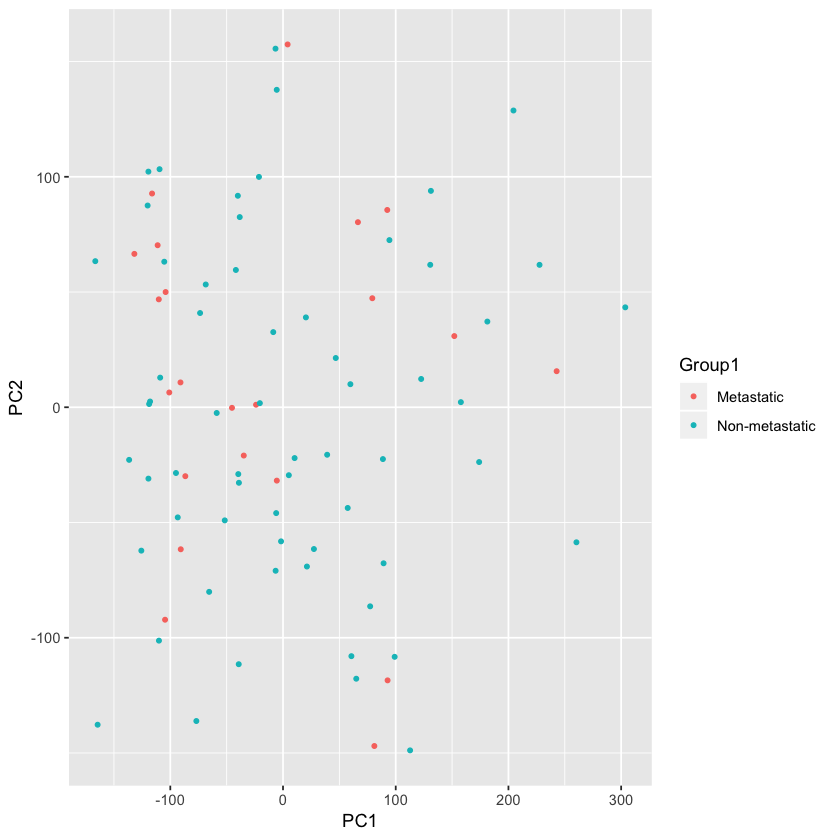

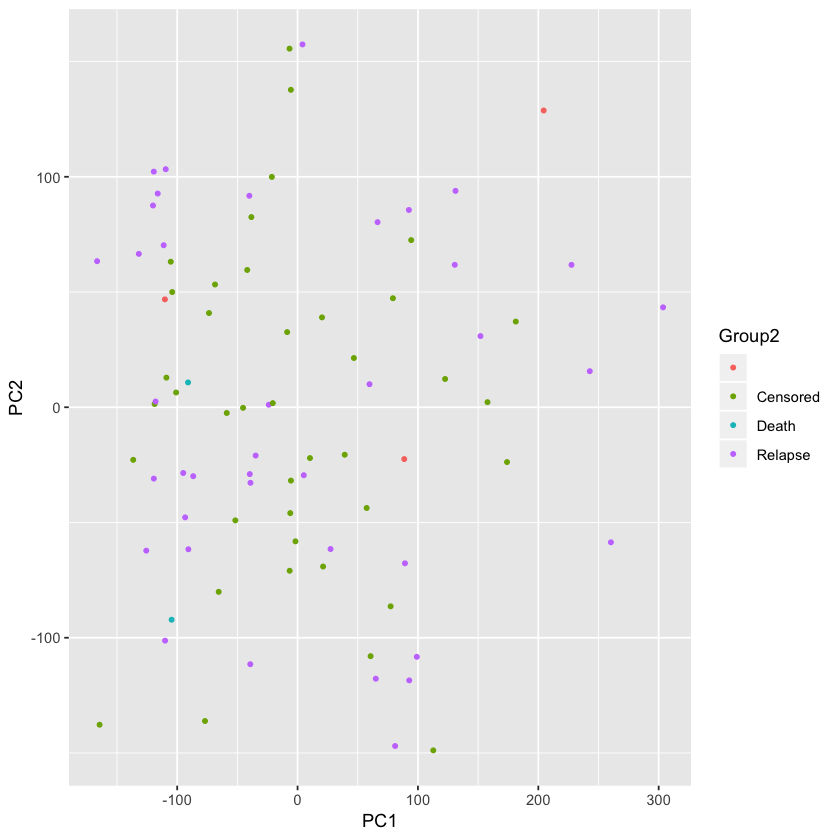

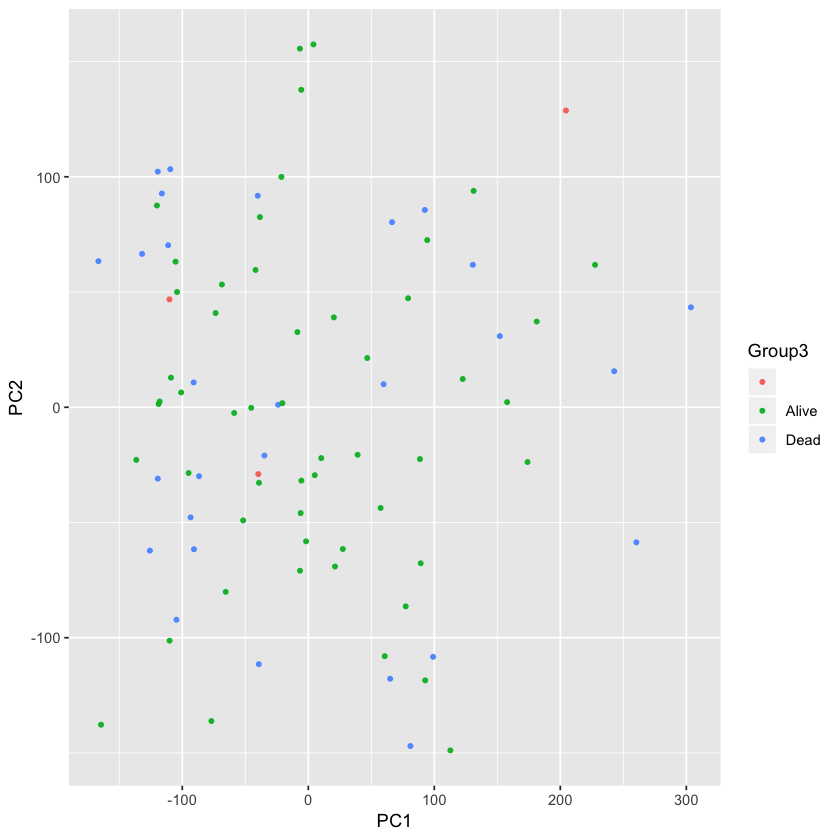

In [6]:
# PCA of VIPER protein activity for TARGET samples using pan-cancer interactome
current.pca <- prcomp(x = t(vpmat_meta))
summary(current.pca) # see that PC1 explains 45% of the variance and PC2 21%, thus the first two components account for 66% of the variance
# Plotting the data by the first two PCA components
plot.data <- as.data.frame(current.pca$x[,1:2])
plot.data$Group1 <- DxDisease
plot.data$Group2 <- events
plot.data$Group3 <- VitalStatus
# Coloring samples by metastatic vs. non-metastatic
ggplot(plot.data,aes(x = PC1, y = PC2)) + geom_point(aes(colour = Group1),size = 1)
# Coloring samples by primary event (Censored, Relapse, Death)
ggplot(plot.data,aes(x = PC1, y = PC2)) + geom_point(aes(colour = Group2),size = 1)
# Coloring samples by vital status (Alive, Dead)
ggplot(plot.data,aes(x = PC1, y = PC2)) + geom_point(aes(colour = Group3),size = 1)

## Clustering Analysis of VIPER protein activity

In [8]:
# Will cluster by the top 30 most differentially active proteins by variance across the samples (features)
TopMRs <- vpmat_meta[order(rowVars(vpmat_meta), decreasing=T)[1:30],]

Evaluated cluster tendency or feasibility of clustering analyses using a statistical method -- Hopkins statistic -- and visual assessment of cluster tendency (VAT) algorithm. For Hopkins statistic, H > 0.75 indicates a clustering tendency at the 90% confidence level.

[[1]]
[1] 0.7549057

[[2]]


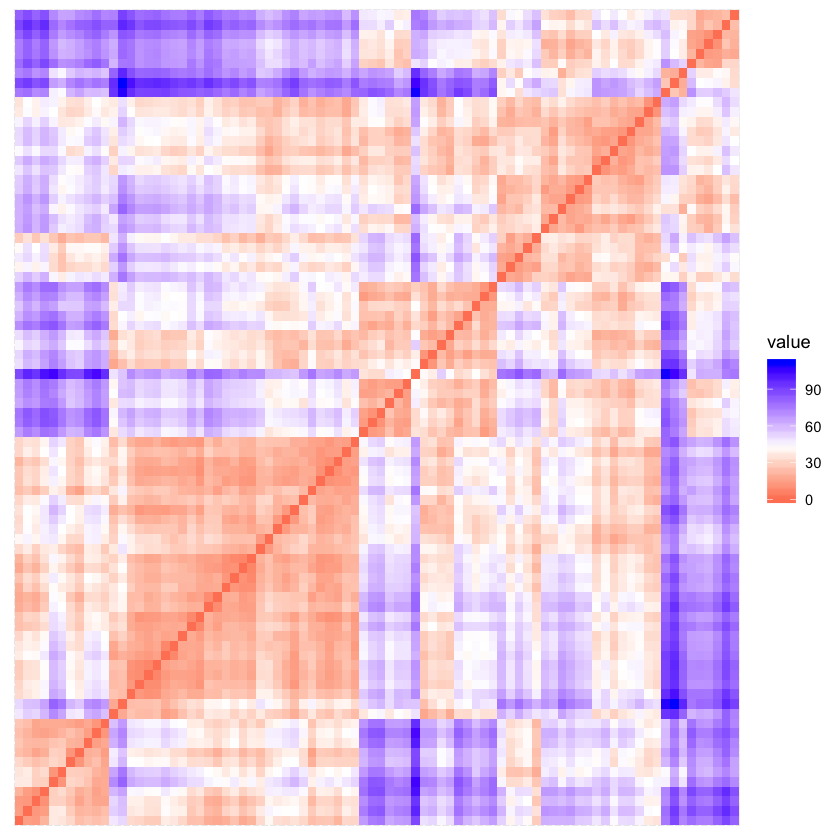

In [126]:
ClusterTendency <- function(vipnes){
  vipnes2 <- t(vipnes)
  HClustTend <- get_clust_tendency(data = vipnes2, n = nrow(vipnes2) - 1, graph = TRUE)
  return(list(HClustTend$hopkins_stat, HClustTend$plot))
}

ClusterTendency(TopMRs) #H = 0.796 when using top 30 most differentially active MRs as featuers
# Suggests a clustering tendency statistically and visually see several clusters of correlated samples (~4) although the data is slightly noisy

Attemped different clustering methods (PAM, hierarchical with different distance metrics) using average silhouette width as a measure of internal cluster quality. Used the NbClust package which returns 30 indices for determining the relevant number of clusters and proposes to users the bst clustering scheme from the different results obtained by varying all combinations of number of clusters, distance meaasures, and clustering methods to get an idea of the optimal clustering strategy for this data.

*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 


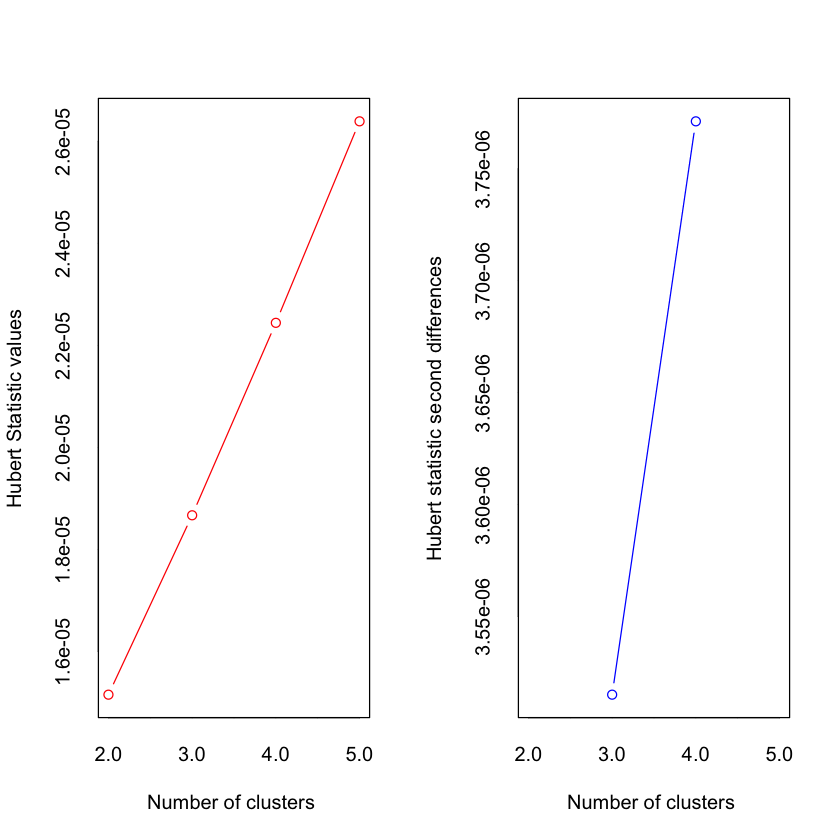

*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 
******************************************************************* 
* Among all indices:                                                
* 2 proposed 2 as the best number of clusters 
* 5 proposed 3 as the best number of clusters 
* 7 proposed 4 as the best number of clusters 
* 6 proposed 5 as the best number of clusters 

                   ***** Conclusion *****                            
 
* According to the majority rule, the best number of clusters is  4 
 
 
******************************************************************* 
Among all indices: 
* 2 proposed  0 as the best number of clusters
* 1 proposed  1 as the best number of clusters
* 2 proposed  2 as the best number

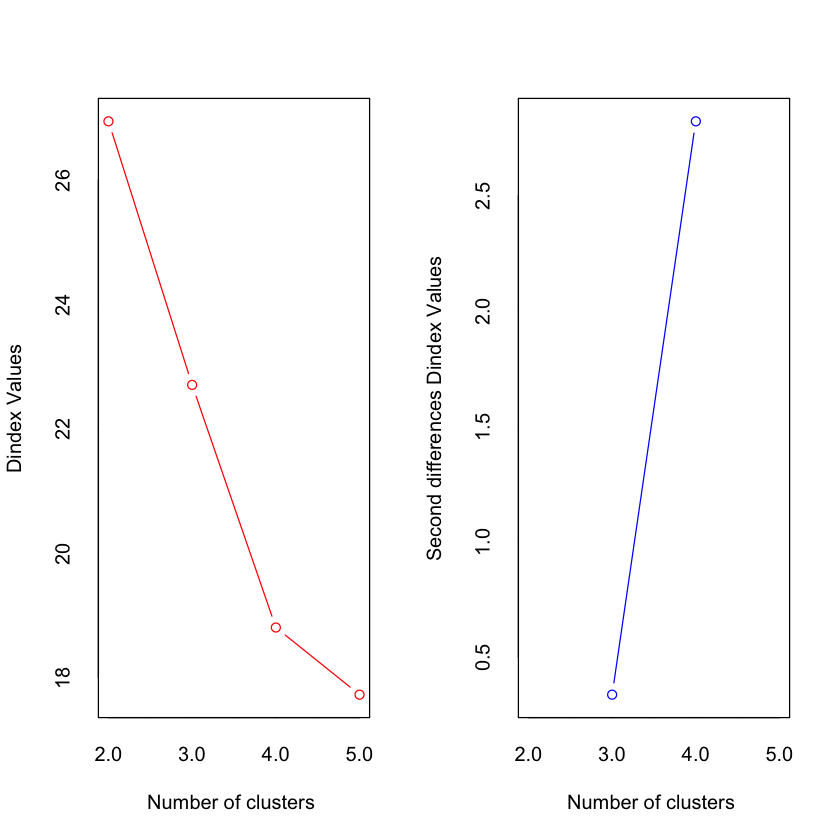

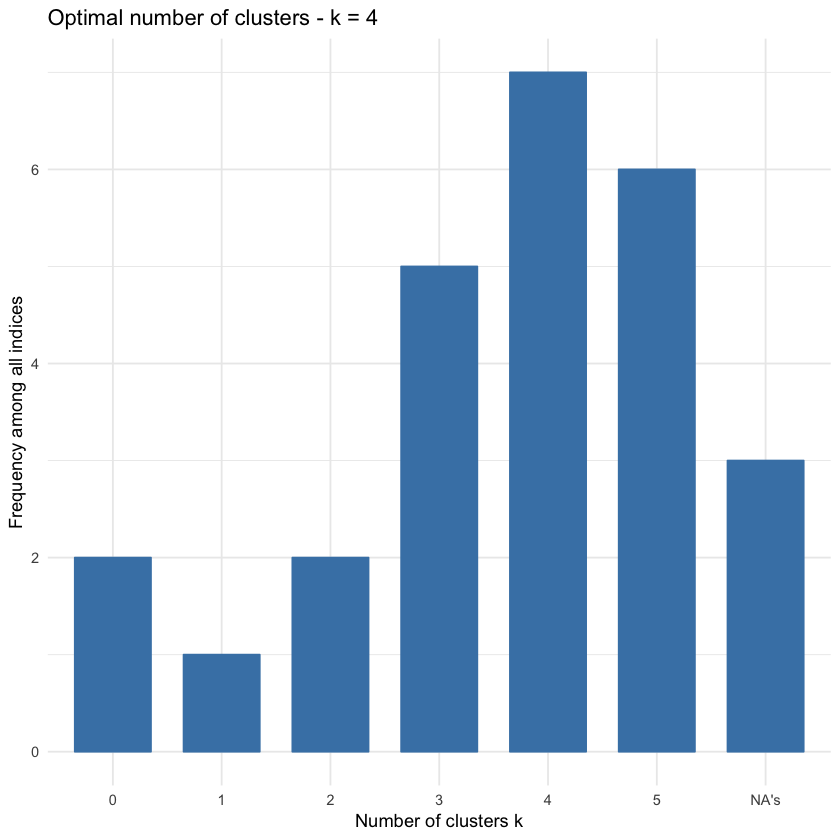

In [127]:
# Determine optimal clustering strategy (number of clusters, distance metric, clustering method).
# Results suggest dividing samples in to 4 clusters is optimal.
set.seed(123)
res.nb <- NbClust(data = t(TopMRs), diss = NULL, distance = "euclidean", min.nc = 2, max.nc = 5, method = "complete", index = "all")
fviz_nbclust(res.nb) + theme_minimal()

## PAM (Partitioning Around Mediods) Clustering

  cluster size ave.sil.width
1       1   34          0.31
2       2   18          0.35
3       3   21          0.24
4       4   11          0.41


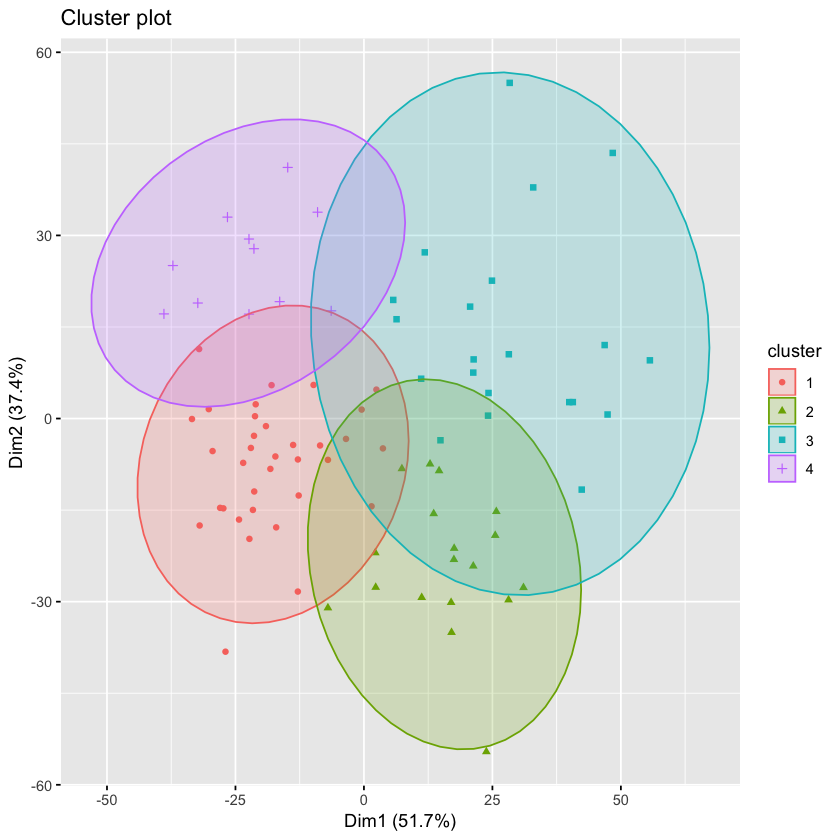

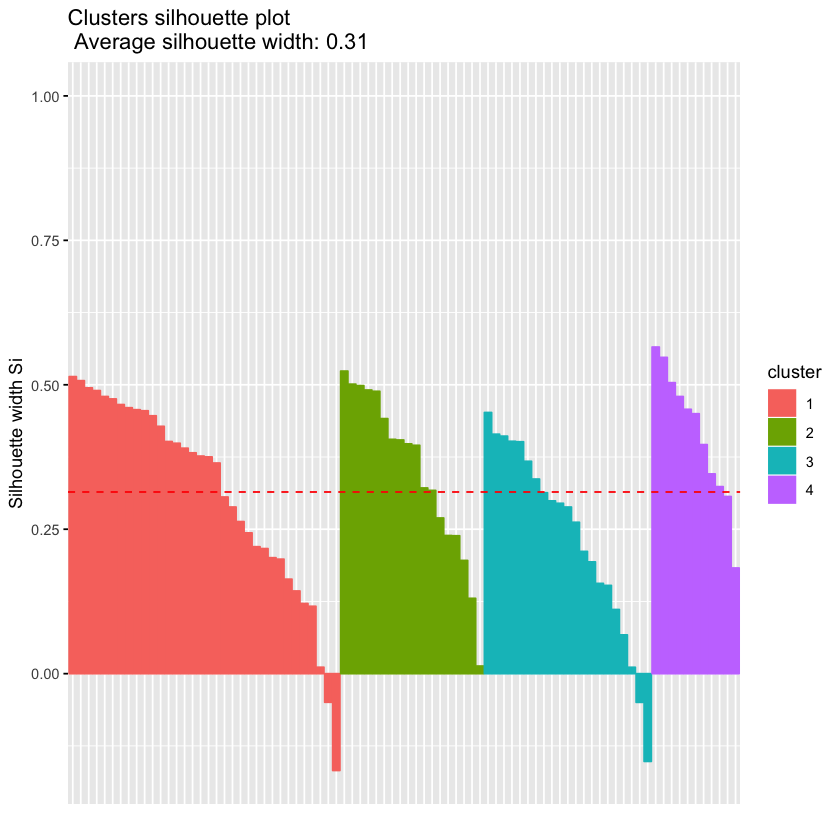

In [10]:
# Set k=4 based on above analysis
pam.res <- pam(t(TopMRs), 4)
pamClusterAssignment <- pam.res$clustering
fviz_cluster(pam.res, stand = FALSE, geom = "point", ellipse.type = "norm")
# Evaluating silhouette width for PAM clustering
pamSampleDistance <- dist(t(TopMRs), method = "euclidean")
pamsil <- silhouette(pamClusterAssignment, pamSampleDistance)
fviz_silhouette(pamsil)

## Hierarchical Clustering

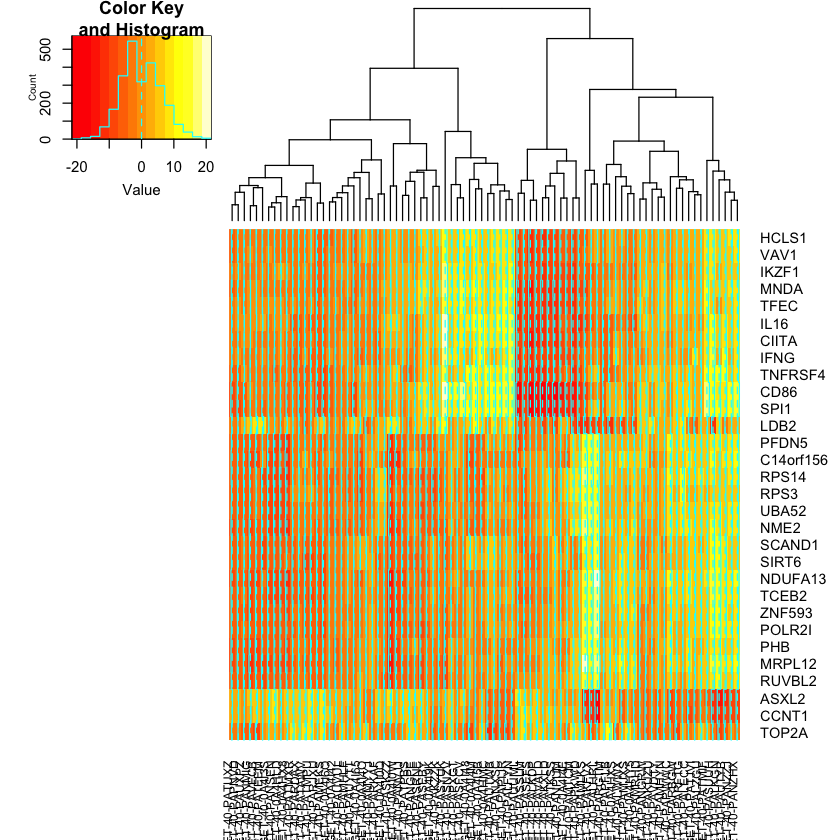

In [11]:
hm_ED <- heatmap.2(x = TopMRs %>% as.matrix, dendrogram = "column")
# With visual inspection and prior analyses, we decided to cut the dendrogram at 4 clusters
# We obtained a similar average silhouette width as PAM clustering with 2 clusters having relatively higher silhouette widths suggesting that these might be informative clusters.
SampleClusters <- as.hclust(hm_ED$colDendrogram)
ClusterAssignment <- cutree(SampleClusters, k = 4)
sidecols2 <- brewer.pal(4, "Set1")[ClusterAssignment]

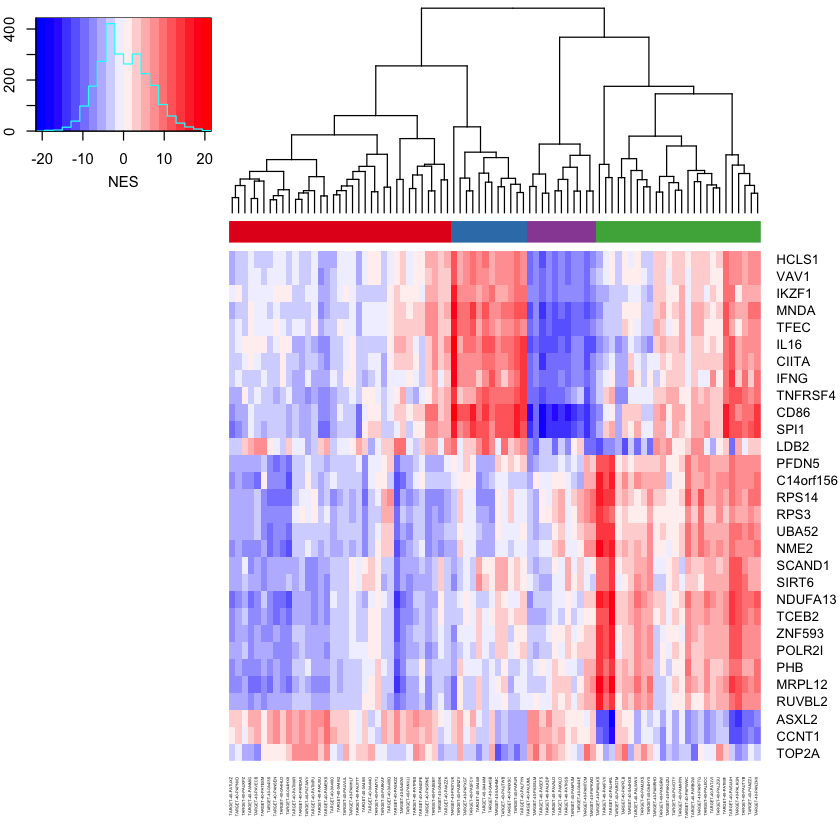

In [12]:
hm_ED <- heatmap.2(x = TopMRs %>% as.matrix, dendrogram = "column",
                   col = colorRampPalette(c('blue','white','red'))(n=20),
                   ColSideColors = sidecols2, 
                   trace = "none", cexCol = 0.3, cexRow = 1,
                   key.title = NA, key.xlab = "NES", key.ylab = NA)

Calculating silhouette width for hierarchical clustering with 4 final clusters

  cluster size ave.sil.width
1       1   35          0.30
2       2   12          0.45
3       3   26          0.16
4       4   11          0.45


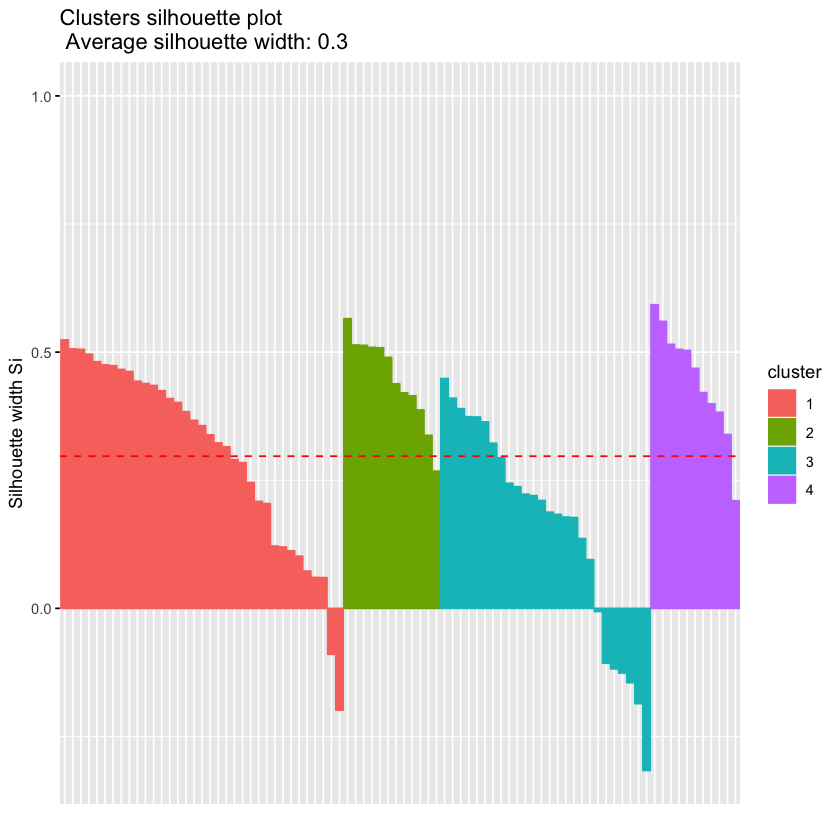

In [13]:
SampleDistance <- dist(t(TopMRs), method = "euclidean")
sil <- silhouette(ClusterAssignment, SampleDistance)
fviz_silhouette(sil) # 4 clusters seems to optimize average silhouette width and visual assessment for our data
# With 5 clusters have 4 moderate strength clusters and one larger weak cluster

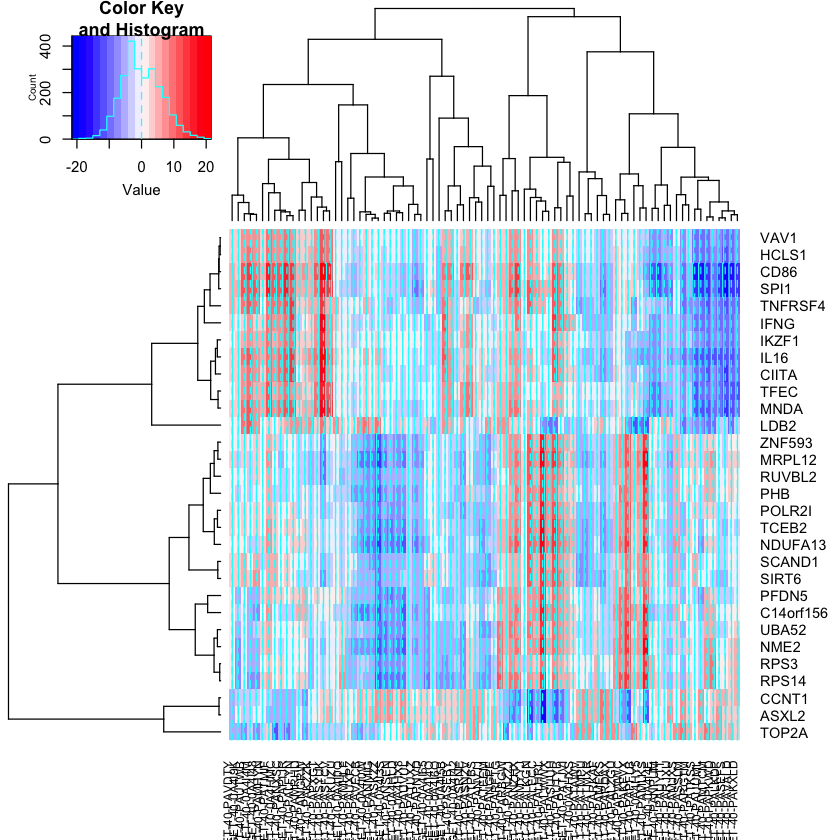

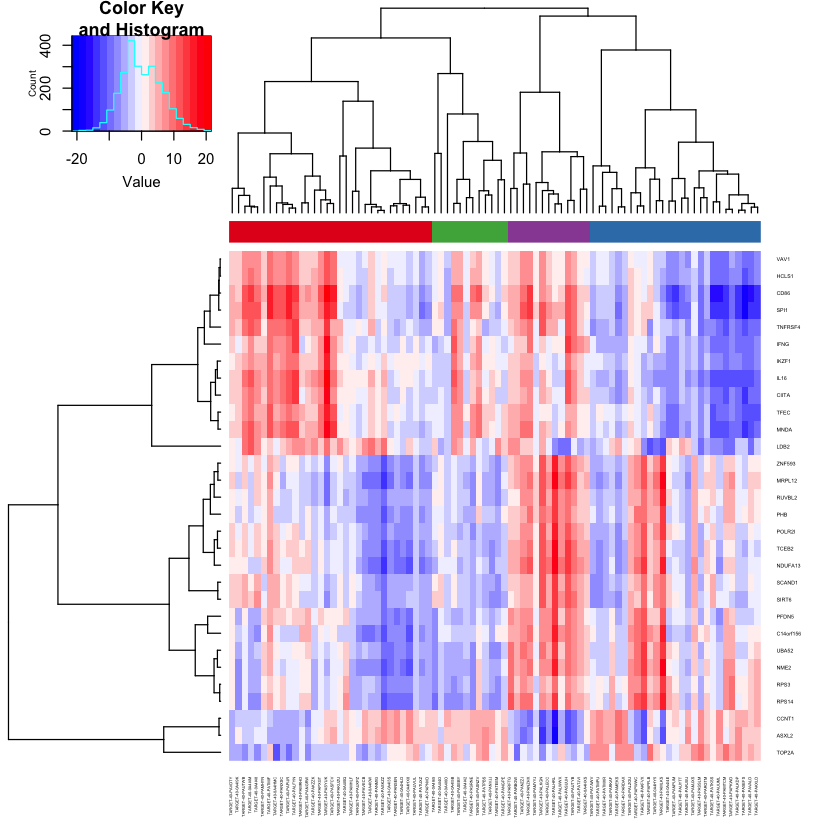

In [131]:
# Clustering using spearman correlation and complete linkage showed less robust clusters
TopMRs %<>% as.matrix
hc <- hclust(as.dist(1-cor(TopMRs, method='spearman')), method ='complete')
hr <- hclust(as.dist(1-cor(t(TopMRs), method='spearman')), method ='complete')
hm_spearman <- heatmap.2(TopMRs, col = colorRampPalette(c('blue','white','red'))(n=20), 
                         Rowv=as.dendrogram(hr),
                         Colv=as.dendrogram(hc))

SampleClusters_spearman <- as.hclust(hm_spearman$colDendrogram)
ClusterAssignment_spearman <- cutree(SampleClusters_spearman, k = 4)
sidecols_spearman <- brewer.pal(4, "Set1")[ClusterAssignment_spearman]

hm_spearman <- heatmap.2(TopMRs, col = colorRampPalette(c('blue','white','red'))(n=20), 
                         Rowv=as.dendrogram(hr),
                         Colv=as.dendrogram(hc),
                         ColSideColors = sidecols_spearman, trace = "none",
                         cexRow = 0.4, cexCol = 0.3)

  cluster size ave.sil.width
1       1   32          0.16
2       2   27          0.30
3       3   12          0.09
4       4   13          0.47


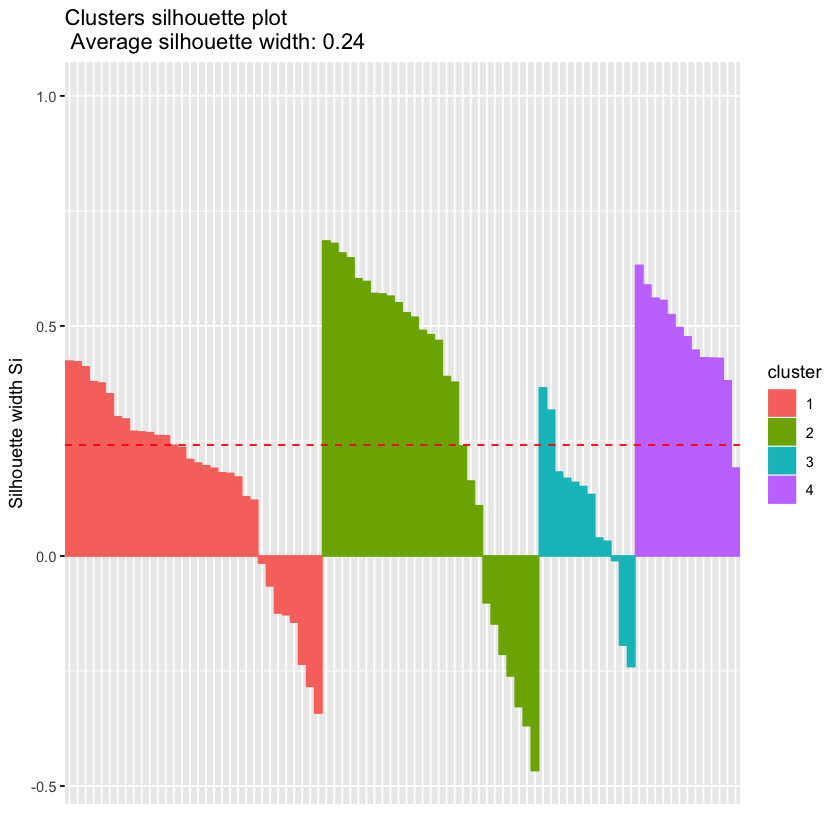

In [132]:
# Evaluating silhouette widths for this clustering method - shows worse average silhouette width of 0.24
SampleDistance2 <- as.dist(1-cor(TopMRs, method = 'spearman'))
sil2 <- silhouette(ClusterAssignment_spearman, SampleDistance2)
fviz_silhouette(sil2)

## Evaluating associations between MR Clusters and Phenotypes/Outcomes
Here we used the MR cluster assignments as obtained from the hierarchical clustering using Euclidean distance and dividing in to 4 clusters as this optimized our silhouette widths and general appearance/eveneness of the clusters.

In [14]:
# MR Cluster vs. Relapse Disease
RelapseEvent <- as.matrix(events[1:81]) # exclude 3 with missing info
RelapseEvent <- replace(RelapseEvent, RelapseEvent == "Relapse", 1)
RelapseEvent <- replace(RelapseEvent, RelapseEvent == "Death", 1)
RelapseEvent <- replace(RelapseEvent, RelapseEvent == "Censored", 0)
ClusterAssignment2 <- as.matrix(ClusterAssignment)
rows <- intersect(rownames(ClusterAssignment2), rownames(RelapseEvent))
RelapsebyCluster <- cbind(ClusterAssignment2[rows,], RelapseEvent[rows,])
RelapsebyCluster <- as.data.frame(RelapsebyCluster)
RelapseCT <- as.matrix(table(RelapsebyCluster))

In [15]:
# Ran Chi-squared test
chisq.test(RelapseCT) 
# As some category values were <5, ran Fisher's exact test instead
fisher.test(RelapseCT) 

Warning message in chisq.test(RelapseCT):
“Chi-squared approximation may be incorrect”


	Pearson's Chi-squared test

data:  RelapseCT
X-squared = 6.2898, df = 3, p-value = 0.09833



	Fisher's Exact Test for Count Data

data:  RelapseCT
p-value = 0.1002
alternative hypothesis: two.sided


In [16]:
# Pairwise chi-squared test for relapse
pairwiseNominalIndependence(RelapseCT, fisher=TRUE, gtest=FALSE, chisq=FALSE, method="none")

Comparison,p.Fisher,p.adj.Fisher
<chr>,<dbl>,<dbl>
1 : 2,0.0229,0.0229
1 : 3,0.1840,0.1840
1 : 4,0.4730,0.4730
2 : 3,0.3060,0.3060
2 : 4,0.3780,0.3780
3 : 4,1.0000,1.0000


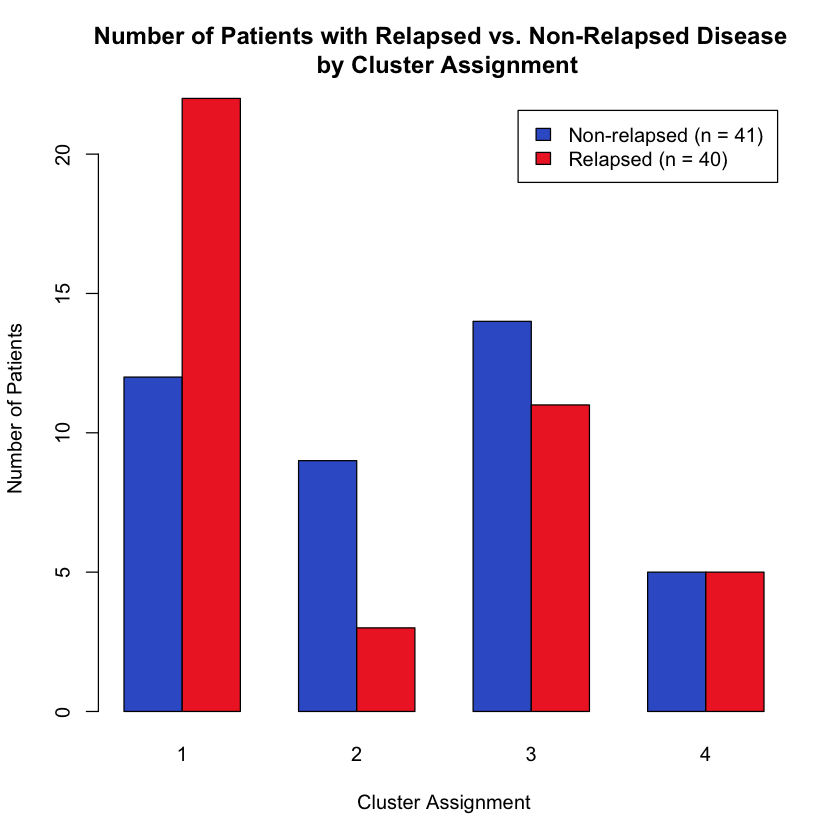

In [136]:
barplot(t(RelapseCT), beside = TRUE, 
        legend.text = c("Non-relapsed (n = 41)", "Relapsed (n = 40)"), 
        col = c("royalblue3", "firebrick2"), 
        main = "Number of Patients with Relapsed vs. Non-Relapsed Disease \n by Cluster Assignment",
        xlab = "Cluster Assignment",
        ylab = "Number of Patients")

In [17]:
# Used Chi-squared test to evaluate association between cluster assignment and Metastatic vs. Non-Metastatic
Metastatic <- as.matrix(DxDisease)
Metastatic <- replace(Metastatic, Metastatic == "Metastatic", 1)
Metastatic <- replace(Metastatic, Metastatic == "Non-metastatic", 0)
rows2 <- intersect(rownames(ClusterAssignment2), rownames(Metastatic))
MetastaticbyCluster <- cbind(ClusterAssignment2[rows2,], Metastatic[rows2,])
MetastaticbyCluster <- as.data.frame(MetastaticbyCluster)
MetastaticCT <- as.matrix(table(MetastaticbyCluster))
# Ran Chi-squared test
chisq.test(MetastaticCT)
# As some category values were <5, ran Fisher's exact test instead
fisher.test(MetastaticCT) 

Warning message in chisq.test(MetastaticCT):
“Chi-squared approximation may be incorrect”


	Pearson's Chi-squared test

data:  MetastaticCT
X-squared = 2.3708, df = 3, p-value = 0.4991



	Fisher's Exact Test for Count Data

data:  MetastaticCT
p-value = 0.5194
alternative hypothesis: two.sided


In [18]:
# Pairwise chi-squared test
pairwiseNominalIndependence(MetastaticCT, fisher=TRUE, gtest=FALSE, chisq=FALSE, method="none")

Comparison,p.Fisher,p.adj.Fisher
<chr>,<dbl>,<dbl>
1 : 2,0.244,0.244
1 : 3,1.000,1.000
1 : 4,1.000,1.000
2 : 3,0.223,0.223
2 : 4,0.317,0.317
3 : 4,1.000,1.000


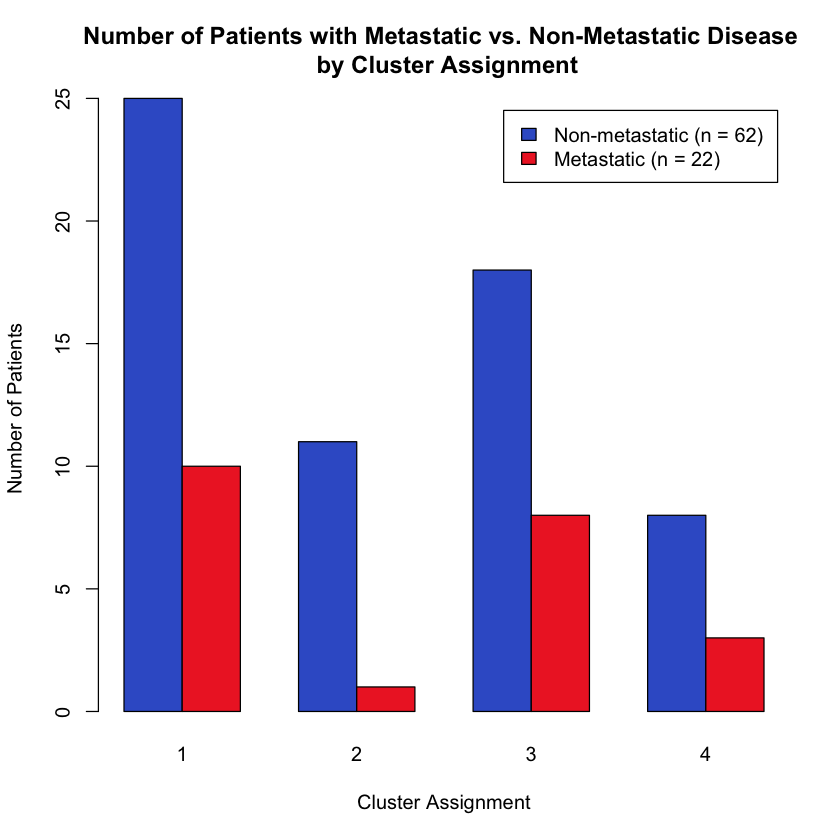

In [139]:
# To illustrate findings of Chi-squared test for metastasis using barplots
barplot(t(MetastaticCT), beside = TRUE, 
        legend.text = c("Non-metastatic (n = 62)", "Metastatic (n = 22)"), 
        col = c("royalblue3", "firebrick2"), 
        main = "Number of Patients with Metastatic vs. Non-Metastatic Disease \n by Cluster Assignment",
        xlab = "Cluster Assignment",
        ylab = "Number of Patients")

In [140]:
# Used log-rank test and kaplan meier curves to evaluate differences between cluster assignment and EFS and OS
# Overall survival:
rownames(target.clinical) <- target.clinical$`TARGET.USI`
joint <- intersect(rownames(ClusterAssignment2), rownames(target.clinical))
ClinicalCluster <- cbind(ClusterAssignment2[joint,], target.clinical[joint,])
survival_data <- ClinicalCluster %>% select(`Overall.Survival.Time.in.Days`, `Vital.Status`, `ClusterAssignment2[joint, ]`)
survival_data <- survival_data %>% mutate(status = as.factor(`Vital.Status`)) %>% mutate(cluster = as.factor(`ClusterAssignment2[joint, ]`) %>% as.factor)
survival_data <- survival_data[complete.cases(survival_data),]
survival_data <- survival_data %>% mutate(cluster_bin = c(1,2,3,4)[cluster]) %>% mutate(days = `Overall.Survival.Time.in.Days`)
survival_data <- survival_data[!survival_data$Vital.Status == "",]
survival_data$Vital.Status %<>% factor(levels = c("Alive", "Dead"))
survival_data$status_bin <- c(0,1)[survival_data$Vital.Status] %>% as.numeric

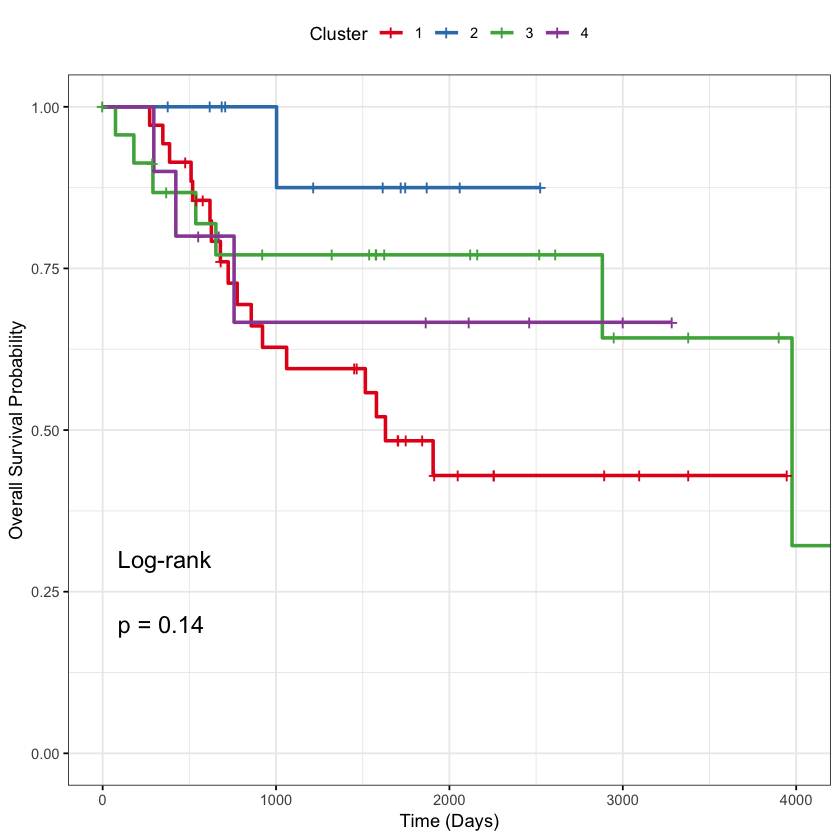

In [141]:
# Comparison using log-rank test which is slightly different from Cox proportional hazards
fit <- survfit(Surv(days, status_bin) ~ cluster, data =  survival_data)
# Plotting Kaplan Meirer survival curves with results of the log-rank test
ggsurvplot(fit, 
           legend.title = "Cluster",
           legend.labs = c("1", "2", "3", "4"),
           pval = TRUE,
           pval.method = TRUE,
           conf.int = FALSE,
           # Add risk table
           #risk.table = TRUE,
           #tables.height = 0.2,
           #tables.theme = theme_cleantable(),
           ylab = "Overall Survival Probability",
           xlab = "Time (Days)",
           cex.lab = 10,
           palette = brewer.pal(4, "Set1"),
           ggtheme = theme_bw() 
)

In [142]:
# Also did pairwise comparison between clusters using log-rank test
OS_pairwise_pvalues <- pairwise_survdiff(Surv(days, status_bin) ~ cluster, data = survival_data, p.adjust.method = "none", rho = 0)
# No statistical difference when looking between all groups. Pairwise comparison shows statistical difference between MR groups 1 and 2 with p value 0.042 only when you don't adjust for multiple hypothesis testing, otherwise no difference.
OS_pairwise_pvalues


	Pairwise comparisons using Log-Rank test 

data:  survival_data and cluster 

  1     2     3    
2 0.042 -     -    
3 0.131 0.321 -    
4 0.453 0.195 0.856

P value adjustment method: none 

In [143]:
# Event-free survival (survival until a first event (relapse, death, secondary malignancy))
survival_data2 <- ClinicalCluster %>% select(`Time.to.First.Event.in.Days`, `Vital.Status`, `ClusterAssignment2[joint, ]`)
survival_data2 <- survival_data2 %>% mutate(status = as.factor(`Vital.Status`)) %>% mutate(cluster = as.factor(`ClusterAssignment2[joint, ]`) %>% as.factor)
survival_data2 <- survival_data2[complete.cases(survival_data2),]
survival_data2 <- survival_data2 %>% mutate(cluster_bin = c(1,2,3,4)[cluster]) %>% mutate(days2 = `Time.to.First.Event.in.Days`)
survival_data2 %<>% filter(Vital.Status == "Alive" | Vital.Status == "Dead")
survival_data2$Vital.Status %<>% factor(levels = c("Alive", "Dead"))
survival_data2$status_bin <- c(0,1)[survival_data2$Vital.Status] %>% as.numeric
# Comparison using log-rank test which is slightly different from Cox proportional hazards
fit_EFS <- survfit(Surv(days2, status_bin) ~ cluster, data =  survival_data2)

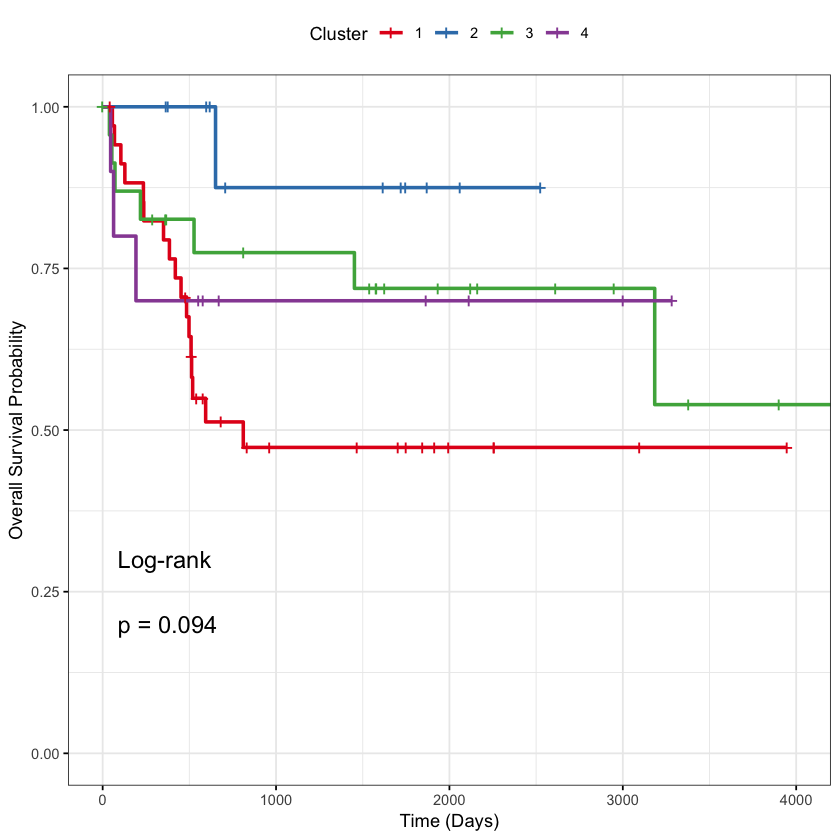

In [144]:
# Comparison using log-rank test which is slightly different from Cox proportional hazards
fit_EFS <- survfit(Surv(days2, status_bin) ~ cluster, data =  survival_data2)
# Plotting Kaplan Meirer survival curves with results of the log-rank test
ggsurvplot(fit_EFS, 
           legend.title = "Cluster",
           legend.labs = c("1", "2", "3", "4"),
           pval = TRUE,
           pval.method = TRUE,
           conf.int = FALSE,
           # Add risk table
           #risk.table = TRUE,
           #tables.height = 0.2,
           #tables.theme = theme_cleantable(),
           ylab = "Overall Survival Probability",
           xlab = "Time (Days)",
           cex.lab = 10,
           palette = brewer.pal(4, "Set1"),
           ggtheme = theme_bw() 
)

In [145]:
# Also did pairwise comparison between clusters using log-rank test
OS_pairwise_pvalues_EFS <- pairwise_survdiff(Surv(days2, status_bin) ~ cluster, data =  survival_data2, p.adjust.method = "none")
# No statistical difference when looking between all groups. Pairwise comparison shows statistical difference between MR groups 1 and 2 with p value 0.042 only when you don't adjust for multiple hypothesis testing, otherwise no difference.
OS_pairwise_pvalues_EFS


	Pairwise comparisons using Log-Rank test 

data:  survival_data2 and cluster 

  1     2     3    
2 0.021 -     -    
3 0.138 0.245 -    
4 0.437 0.176 0.861

P value adjustment method: none 

## Identifying MRs of Metastatic Disease
Here we used data from all 161 samples dividing patients by metastatic vs non-metastatic disease status. The code is provided but will not be able to run as you do not have access to the DFCI/UCSF patients.

In [ ]:
### Finding regulators of metastatic disease (55 metastatic vs 89 non-metastatic samples = 144 total)
metsamples <- which(colnames(dset_VSTnorm2) %in% rownames(clinical)[clinical$DiseaseDx == 'Metastatic'])
nmsamples <- which(colnames(dset_VSTnorm2) %in% rownames(clinical)[clinical$DiseaseDx == 'Non-metastatic'])

# Creataing GES for metastatic samples as compared to non-metastatic
metvpsig <- viperSignature(dset_VSTnorm2[,metsamples], dset_VSTnorm2[,nmsamples], per=100)

# metaViper analysis
metvpmat <- viper(metvpsig, regulon=getInteractome(regulonSets('all')))

# Identifying most active/inactive MRs
TopActiveMRs <- metvpmat[order(rowMeans(metvpmat), decreasing = T)[1:10],]
TopInactiveMRs <- metvpmat[order(rowMeans(metvpmat), decreasing = F)[1:10],]
TopAberrantMRs <- rbind(TopActiveMRs, TopInactiveMRs)
AberrantMRs <- as.matrix(rowMeans(TopAberrantMRs))

# Displaying results
AberrantMRs_DF <- data.frame(Protein = rownames(AberrantMRs), NES = AberrantMRs[,1])
heatmap.2(cbind(AberrantMRs_DF$NES, AberrantMRs_DF$NES), trace="n", Colv=NA,
          col = colorRampPalette(c('blue','white','red'))(n=50),
          dendrogram = "none", labCol = "", labRow = AberrantMRs_DF$Protein,
          cexRow = 0.75)